In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import math

In [2]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
#with open(f'{path}/subregion_event_totals.json', 'r') as f:
with open('../event_totals.json', 'r') as f:
    totals = json.load(f)
#del(totals['ww4q'])

In [3]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [4]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [5]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [6]:
totals['ww'] = totals['diboson_ww']
totals['wz'] = totals['diboson_wz']
totals['zz'] = totals['diboson_zz']

In [7]:
columns=['goodjets.msoftdrop', 'goodjets.pt']

In [8]:
def read_files(input_path):
    if ('.parquet' in os.listdir(input_path)[0]):
        output = ak.from_parquet(f'{input_path}/*', columns=columns)
    else:
        output = {}
        for i in os.listdir(input_path):
            if ('flat400' not in i):
                output[i] = ak.from_parquet(f'{input_path}/{i}/*', columns=columns)
            else:
                continue
    return output

In [9]:
region = 'nolepton'
path = '/project01/ndcms/cmoore24/skims/full_skims'

In [10]:
# qcd = read_files(f'{path}/{region}')
# hgg = read_files(f'{path}/{region}')
# hbb = read_files(f'{path}/{region}')
# wqq = read_files(f'{path}/{region}')
# zqq = read_files(f'{path}/{region}')
# ttboosted = read_files(f'{path}/{region}')
# tthadronic = read_files(f'{path}/{region}')
# singletop = read_files(f'{path}/{region}')
# ww = read_files(f'{path}/{region}')
# wz = read_files(f'{path}/{region}')
# zz = read_files(f'{path}/{region}')
mc = read_files(f'{path}/{region}/mc')

In [11]:
mc['ww'] = mc['diboson_ww']
mc['wz'] = mc['diboson_wz']
mc['zz'] = mc['diboson_zz']
del(mc['diboson_ww'])
del(mc['diboson_wz'])
del(mc['diboson_zz'])

In [12]:
# mc = {}
# mc['hgg'] = hgg
# mc['hbb'] = hbb
# mc['singletop'] = singletop
# mc['ww'] = ww
# mc['wz'] = wz
# mc['zz'] = zz
# mc['qcd'] = qcd
# mc['wqq'] = wqq
# mc['zqq'] = zqq
# mc['ttboosted'] = ttboosted
# mc['tthadronic'] = tthadronic

In [13]:
for i in mc:
    if type(mc[i]) == dict:
        for j in mc[i]:
            for k in mc[i][j].fields:
                if 'event' in k:
                    continue
                else:
                    try:
                        mc[i][j][k] = ak.firsts(mc[i][j][k])
                    except:
                        continue
    else:
        for j in mc[i].fields:
            if 'event' in j:
                continue
            else:
                try:
                    mc[i][j] = ak.firsts(mc[i][j])
                except:
                    continue

In [14]:
# data = {}
# data['B'] = read_files('/project01/ndcms/cmoore24/skims/ecfs/grm_ungrm/ecfs/JetHT2017/nolepton/B')
# data['C'] = read_files('/project01/ndcms/cmoore24/skims/ecfs/grm_ungrm/ecfs/JetHT2017/nolepton/C')
# data['D'] = read_files('/project01/ndcms/cmoore24/skims/ecfs/grm_ungrm/ecfs/JetHT2017/nolepton/D')
# data['E'] = read_files('/project01/ndcms/cmoore24/skims/ecfs/grm_ungrm/ecfs/JetHT2017/nolepton/E')
# data['F'] = read_files('/project01/ndcms/cmoore24/skims/ecfs/grm_ungrm/ecfs/JetHT2017/nolepton/F')
data = read_files(f'{path}/{region}/data')

In [15]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            for k in data[i][j].fields:
                if 'event' in k:
                    continue
                else:
                    try:
                        data[i][j][k] = ak.firsts(data[i][j][k])
                    except:
                        continue
    else:
        for j in data[i].fields:
            if 'event' in j:
                continue
            else:
                try:
                    data[i][j] = ak.firsts(data[i][j])
                except:
                    continue

In [16]:
upper = 950
lower = 475

In [17]:
for i in xsecs:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mask = ((mc[i][j].goodjets.pt >= lower) & (mc[i][j].goodjets.pt <= upper))
            mc[i][j] = mc[i][j][mask]
    else:
        mask = ((mc[i].goodjets.pt >= lower) & (mc[i].goodjets.pt <= upper))
        mc[i] = mc[i][mask]

In [18]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            mask = ((data[i][j].goodjets.pt >= lower) & (data[i][j].goodjets.pt <= upper))
            data[i][j] = data[i][j][mask]
    else:
        mask = ((data[i].goodjets.pt >= lower) & (data[i].goodjets.pt <= upper))
        data[i] = data[i][mask]

In [19]:
data_s = {}
for i in data:
    if "Jet" in i:
        data_s[i] = data[i]

In [20]:
# data_dict = {}
# for i in data:
#         data_dict[i] = ak.concatenate([data[i][j] for j in data[i]])
# data_arr = ak.concatenate([data_dict[i] for i in data_dict])
data_arr = ak.concatenate([data[i] for i in data_s])

In [21]:
data_hist = hist.Hist.new.Reg(40, 475, 950, name='msd', label='Data MSD').Weight()
data_hist.fill(msd=data_arr.goodjets.pt);

In [22]:
def msd_hist(dataset, call):
    make_hist = hist.Hist.new.Reg(40, 475, 950, name='msd', label='MC MSD').Weight()
    make_hist.fill(msd=dataset.goodjets.pt)
    return make_hist

In [23]:
mc2 = {}
for i in xsecs:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mc2[j] = mc[i][j]
    else:
        mc2[i] = mc[i]
mc = mc2

In [24]:
hists = {}
for i in mc:
    if type(mc[i]) == dict:
        hists[i] = {}
        for j in mc[i]:
            hists[i][j] = msd_hist(mc[i][j])
    else:
        hists[i] = msd_hist(mc[i], j)

In [25]:
IL = 44.99

In [26]:
scaleHgg = ((IL*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hists['hgg'].view(flow=True)[:] *= scaleHgg

scaleHbb = ((IL*(xsecs['hbb']*1000)*0.581)/(totals['hbb']))
hists['hbb'].view(flow=True)[:] *= scaleHbb

In [27]:
# xsecs['qcd_300to470'] = 6833
# xsecs['ttboosted_700to1000'] = 64.55
# xsecs['ttboosted_1000toInf'] = 16.45
xsecs['tthadronic'] = 687.1

In [28]:
# totals['qcd_300to470'] = 20000000

In [29]:
for i in mc:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((IL*(xsecs[i]*1000))/(totals[i]))
        hists[i].view(flow=True)[:] *= scale

In [30]:
mc_hist = sum(hists[i] for i in hists)

In [31]:
qcd = sum([hists[i] for i in hists if 'qcd' in i])

In [32]:
wqq = sum([hists[i] for i in hists if 'wqq' in i])

In [33]:
zqq = sum([hists[i] for i in hists if 'zqq' in i])

In [34]:
ttboosted = sum([hists[i] for i in hists if 'ttboosted' in i])

In [35]:
new_hists = {}
new_hists['qcd'] = qcd
new_hists['wqq'] = wqq
new_hists['zqq'] = zqq
new_hists['ttboosted'] = ttboosted
new_hists['hbb'] = hists['hbb']
new_hists['hgg'] = hists['hgg']
new_hists['singletop'] = hists['singletop']
new_hists['ww'] = hists['ww']
new_hists['wz'] = hists['wz']
new_hists['zz'] = hists['zz']
new_hists['tthadronic'] = hists['tthadronic']

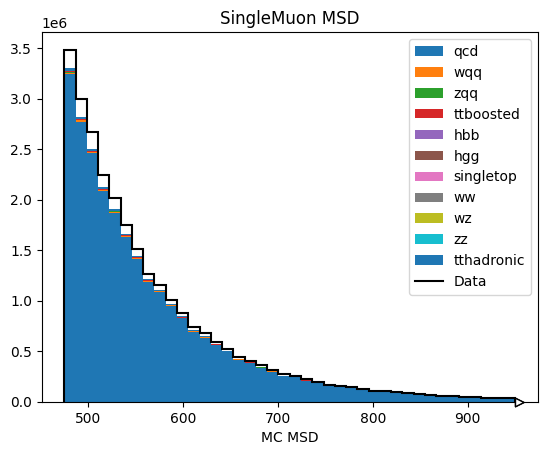

In [59]:
labels = [names for names in new_hists]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', label=labels, density=False)
data_hist.plot1d(label='Data', density=False, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('SingleMuon MSD')
#plt.yscale('log')
plt.show()

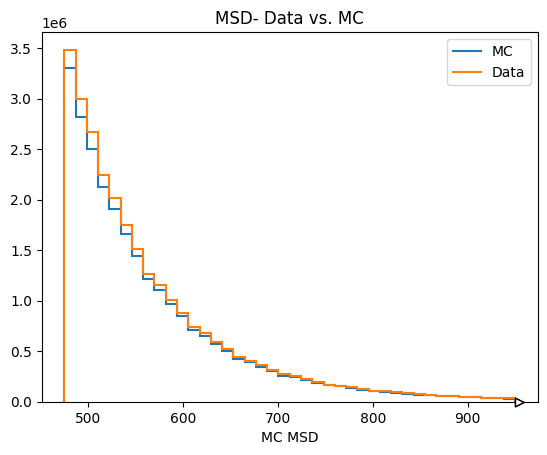

In [38]:
mc_hist.plot1d(label='MC', density=False, yerr=False)
data_hist.plot1d(label='Data', density=False, yerr=False)
plt.legend()
plt.title('MSD- Data vs. MC')
plt.show()

In [39]:
total = 0
for i in hists:
    total += sum(hists[i].values())
total

26048255.167680304

In [40]:
sum(data_hist.values())

27401710.0

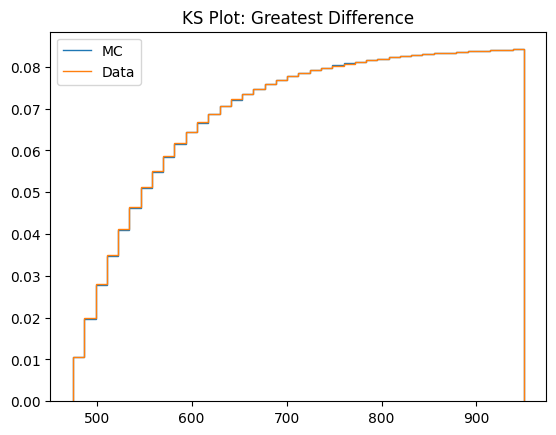

In [41]:
fig, ax = plt.subplots()

ax.stairs(np.cumsum(mc_hist.density()), edges=mc_hist.axes[0].edges, label='MC');
ax.stairs(np.cumsum(data_hist.density()), edges=data_hist.axes[0].edges, label='Data');
plt.legend()
plt.title('KS Plot: Greatest Difference')
plt.show()

In [58]:
-math.log10(abs(np.cumsum(mc_hist.density() * 11.875) - np.cumsum(data_hist.density() * 11.875)).max())

2.47995593168125

In [43]:
# Assuming mc_hist and data_hist are numpy.histogram outputs (values, bin_edges)
mc_values, mc_bins = mc_hist.to_numpy()
data_values, data_bins = data_hist.to_numpy()

# Normalize the histograms to represent densities
mc_density = mc_values / mc_values.sum()  # Normalize to sum to 1
data_density = data_values / data_values.sum()

# Compute the CDFs
mc_cdf = np.cumsum(mc_density)
data_cdf = np.cumsum(data_density)

# Compute the KS statistic as the maximum absolute difference between the CDFs
ks_statistic = np.max(np.abs(mc_cdf - data_cdf))
print(f"KS Statistic: {ks_statistic}")
print(f"Adjusted: {-math.log10(ks_statistic)}")

KS Statistic: 0.0033116472341123693
Adjusted: 2.479955931681235


In [57]:
np.cumsum(mc_hist.density())*11.875

array([0.12667563, 0.23502519, 0.33115621, 0.41267507, 0.48582717,
       0.54959543, 0.60495801, 0.6514926 , 0.69399604, 0.73116995,
       0.7635746 , 0.79078958, 0.81566946, 0.83764551, 0.85689993,
       0.87325401, 0.88834611, 0.9015542 , 0.9132549 , 0.92317321,
       0.93241414, 0.94059048, 0.94787439, 0.95404524, 0.95983303,
       0.96499829, 0.96957923, 0.9735233 , 0.9772271 , 0.98056303,
       0.98355111, 0.98611549, 0.98854026, 0.9907271 , 0.99271535,
       0.99442815, 0.9960471 , 0.99751458, 0.99884429, 1.        ])